In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy
import scipy.special
import matplotlib.pyplot as plt
pi=np.pi

import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

import matplotlib
cmap = matplotlib.cm.get_cmap('Dark2')
ct = cmap(np.linspace(0,1,4))

def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

In [2]:
from cycler import cycler
cyc = cycler(color=[ct[2], ct[0], 'r'])
nams = ['UnAware','Aware','Over-Aware']

In [3]:
def poisson_expect(expect,actual): return expect**actual/scipy.special.factorial(actual) * np.exp(-expect)

def c(s_0,s_1=0,lam=10/90*pi,gamma=2): ## eq 7
    full = np.exp(-1/(2*lam**2)*np.abs(wrap_rad(s_0-s_1))**gamma)
    return full/np.sum(full,0)*len(s_0)

def cf(s_0,s_1=0,lam=20/90*pi,gamma=2,p_same=0.64): ## eq 6  #10, 2, 0.9 (note p_same from BB&J2019 empiricial prior)
    return p_same*c(s_0,s_1,lam,gamma) + (1-p_same)

def gauss(x,mu=0,sig=1): return 1/np.sqrt(2*pi*sig**2)*np.exp(-((x-mu)**2)/(2*sig**2))
def std_e(x): return np.std(x,0)/np.sqrt(len(x))

def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

def wrap_rad(x):
    x[np.abs(x)>pi]-=2*pi*np.sign(x[np.abs(x)>pi])
    return x

In [4]:
N_units=100
N_stim=91
N_probe=720 # 'resolution of model', 360 is good, go higher (1440) for publication quality figs



kappa_n = 1.0 #0.25 # note this is wider than normal units but fine here for simplicity
gamma_n = 1.0
kappa_1 = 0.0
kappa_a = kappa_n
                              
Phi = np.expand_dims(np.linspace(-pi,pi-(2*pi/N_units),N_units),1) #- tuning curve centers
theta_n = np.linspace(-pi,pi-(pi/N_stim),N_stim)[::-1]           #- stimulus probes
ori = np.linspace(-pi,pi-(pi/N_probe),N_probe)                   #- stimuli to sample for likelihood

# for model visualization
theta_n1 = 0 # adapting stim (rad) 
resp_n = gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-theta_n))-1)  #- non-adapted response (for vis model)
TC_n = np.expand_dims(gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-ori))-1),1) # expected non-adapted response (for vis model)

default_var = {'gam_1':0.15,'gam_s':0.6,'sd':0.15,'lam':0.6}

N_brute = 8
sd = 0.15 # default

theta_deg = theta_n/pi*90
stp_size = 2*pi/N_probe

In [5]:
# gam_1,gam_s = (0.8,.9)
gam_1,gam_s = (0.6,.8)
gam_1_2,gam_s_2 = (gam_1*1.5,gam_s)
# gam_1_2,gam_s_2 = (.95,.95)
lam=0.9
do_poisson = .5
this_ori_prev=0
add_constant_adapt = 0


# implement adaptation on population
adapt_shape = np.minimum(0,-gam_1*np.cos(wrap_rad(Phi-theta_n1)*gam_s)**3)     #- adaptation shape (neuron x trial)
gamma_a =adapt_shape+gamma_n -np.mean(adapt_shape,0)*add_constant_adapt #- normalized gain (neuron x trial)

adapt_shape_2 = np.minimum(0,-gam_1_2*np.cos(wrap_rad(Phi-theta_n1)*gam_s_2)**3)     #- adaptation shape (neuron x trial)
gamma_a_2 =adapt_shape_2+gamma_n -np.mean(adapt_shape_2,0)*add_constant_adapt #- normalized gain (neuron x trial)

TC_a = np.expand_dims(gamma_a,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()
TC_a_2 = np.expand_dims(gamma_a_2,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()

resp_a_stim = gamma_a*np.exp(kappa_a*np.cos(wrap_rad(Phi-theta_n))-1)  #- adapted response (neuron x trial)
resp_a_2_stim = gamma_a_2*np.exp(kappa_a*np.cos(wrap_rad(Phi-theta_n))-1)  #- adapted response (neuron x trial)
resp_n_stim = gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-theta_n))-1)  #- adapted response (neuron x trial)

ll_n_n_all = np.sum(np.log(poisson_expect(TC_n*do_poisson,np.expand_dims(resp_n_stim*do_poisson,2))),0)
ll_n_a_all = np.sum(np.log(poisson_expect(TC_n*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
ll_a_a_all = np.sum(np.log(poisson_expect(TC_a*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
ll_a_a_2_all = np.sum(np.log(poisson_expect(TC_a_2*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)

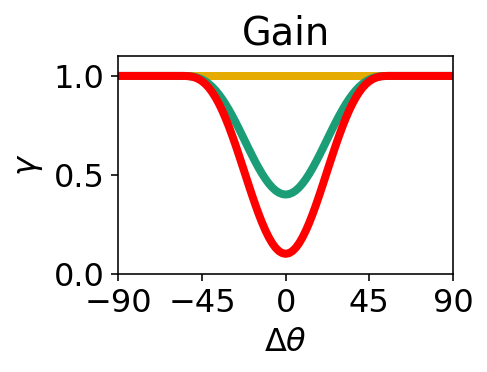

In [6]:
plt.figure(figsize=(3,2))
plt.plot([-90,90],[1,1],linewidth=4,color=ct[2])
plt.plot(Phi*90/pi,gamma_a,linewidth=4,color=ct[0])
plt.plot(Phi*90/pi,gamma_a_2,linewidth=4,color='r')

plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])

plt.title('Gain')

plt.xlabel('$\Delta\\theta$')
plt.ylabel('$\gamma$')
# plt.legend(('No-Adapt','Adapt','Over-Adapt'))
plt.ylim(0,1.1)
# sav_fig('Mdl_demo_Gains')
plt.show()

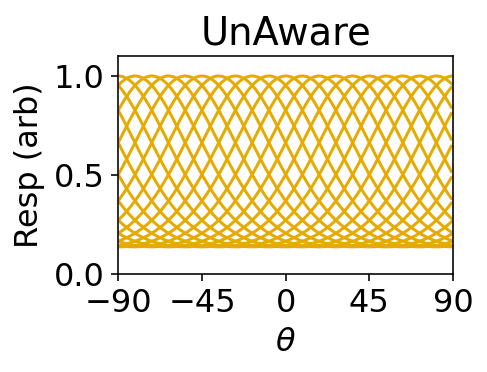

In [7]:
plt.figure(figsize=(3,2))
plt.plot(theta_deg,resp_n_stim[::5,:].T,color=ct[2])
plt.title('UnAware')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('$\\theta$')
plt.ylabel('Resp (arb)')
plt.ylim(0,1.1)
# sav_fig('Mdl_demo_TC_unAware')
plt.show()

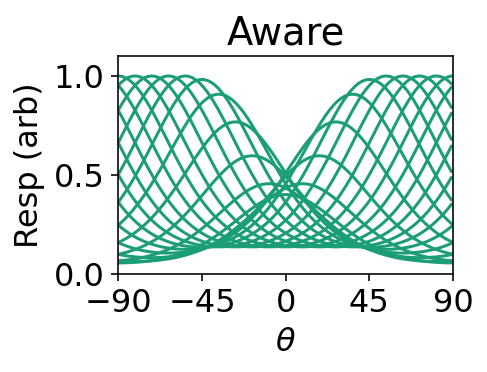

In [8]:
plt.figure(figsize=(3,2))
plt.plot(theta_deg,resp_a_stim[::5,:].T,color=ct[0])
plt.title('Aware')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('$\\theta$')
plt.ylabel('Resp (arb)')

plt.ylim(0,1.1)
# sav_fig('Mdl_demo_TC_Aware')
plt.show()

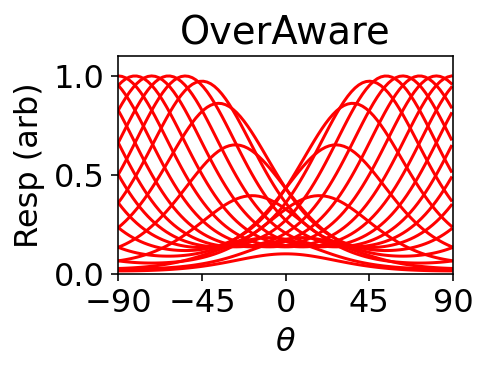

In [9]:
plt.figure(figsize=(3,2))
plt.plot(theta_deg,resp_a_2_stim[::5,:].T,color='r')
plt.title('OverAware')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('$\\theta$')
plt.ylabel('Resp (arb)')

plt.ylim(0,1.1)
# sav_fig('Mdl_demo_TC_overAware')
plt.show()

In [11]:
lam = .8
prior = cf(ori,s_1=theta_n1,lam=lam,)
prior/=np.sum(prior)*stp_size
LIKs = np.array([ll_n_a_all,ll_a_a_all,ll_a_a_2_all]) # ll_n_n_all
max_LIKs = np.array([ori[np.argmax(lik,1)] for lik in LIKs])
E_model = wrap_rad(max_LIKs-theta_n)*90/pi

LIK_Bayes = LIKs + np.log(prior)
max_LIKs_Bayes = np.array([ori[np.argmax(lik,1)] for lik in LIK_Bayes])
E_model_Bayes = wrap_rad(max_LIKs_Bayes-theta_n)*90/pi
# gauss 

Text(0, 0.5, 'Bias (deg)')

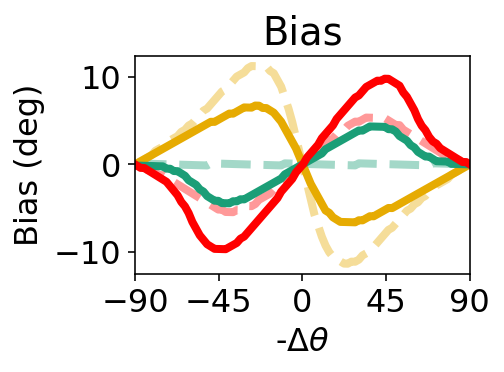

In [22]:
# Bias with model take-aways
# plt.figure(figsize=(8,4))
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)
lw=4
plt.plot(-theta_deg,E_model.T,linewidth=lw,linestyle='--',alpha=.4)
plt.plot(-theta_deg,E_model_Bayes.T,linewidth=lw,linestyle='-')

# plt.legend(('UnAware','B-Aware','OAware','Bayes-Unaware'),ncol=3,loc='lower center')#,bbox_to_anchor=(1,.8))
plt.title('Bias')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('-$\Delta\\theta$')
plt.ylabel('Bias (deg)')
# plt.legend(nams)
# sav_fig('Mdl_demo_Bias_use_all')

Text(0, 0.5, 'Bias (deg)')

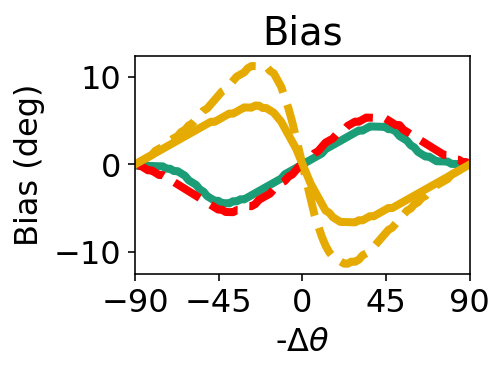

In [13]:
# Bias with model take-aways
# plt.figure(figsize=(8,4))
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)
lw=4
plt.plot(-theta_deg,E_model[0,:],linewidth=lw,linestyle='--')
plt.plot(-theta_deg,E_model_Bayes[1,:],linewidth=lw)
plt.plot(-theta_deg,E_model[2,:],linewidth=lw,linestyle= '--')
plt.plot(-theta_deg,E_model_Bayes[0,:],linewidth=lw)
# plt.plot(-theta_deg,E_model_Bayes[1,:],linewidth=lw)
# plt.plot(-theta_deg,E_model_Bayes[2,:],linewidth=lw)
# plt.legend(('UnAware','B-Aware','OAware','Bayes-Unaware'),ncol=3,loc='lower center')#,bbox_to_anchor=(1,.8))
plt.title('Bias')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('-$\Delta\\theta$')
plt.ylabel('Bias (deg)')
# plt.legend(nams)
# sav_fig('Mdl_demo_Bias_use_dashed')

Text(0, 0.5, 'Bias (deg)')

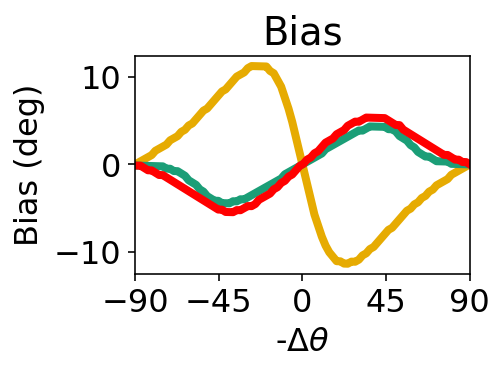

In [14]:
# Bias with model take-aways
# plt.figure(figsize=(8,4))
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)
lw=4
plt.plot(-theta_deg,E_model[0,:],linewidth=lw)#,'--')
plt.plot(-theta_deg,E_model_Bayes[1,:],linewidth=lw)
plt.plot(-theta_deg,E_model[2,:],linewidth=lw)#,'--')
# plt.plot(-theta_deg,E_model_Bayes[0,:])
# plt.legend(('UnAware','B-Aware','OAware','Bayes-Unaware'),ncol=3,loc='lower center')#,bbox_to_anchor=(1,.8))
plt.title('Bias')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('-$\Delta\\theta$')
plt.ylabel('Bias (deg)')
# sav_fig('Mdl_demo_Bias_use')

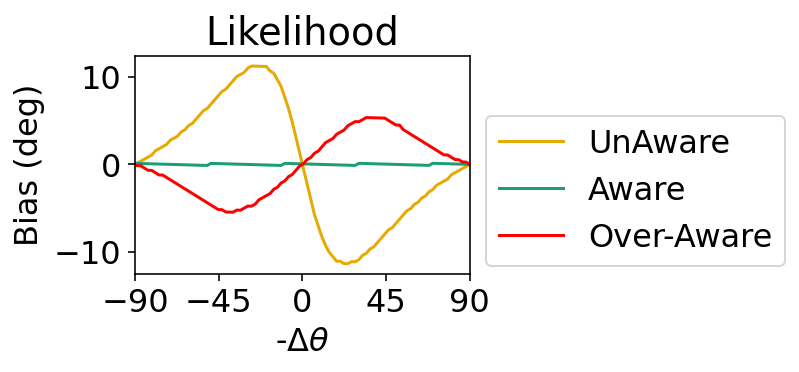

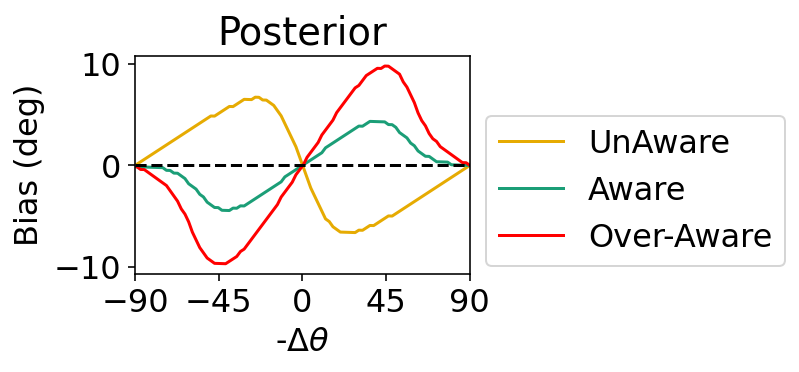

In [18]:
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)

plt.plot(-theta_deg,E_model.T)
# plt.plot([-90,90],[0,0],'k--')
plt.legend(nams,bbox_to_anchor=(1,.8))
plt.title('Likelihood')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('-$\Delta\\theta$')
plt.ylabel('Bias (deg)')
# sav_fig('Mdl_demo_Bias')

plt.show()
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)
# plt.plot([-90,90],[0,0],'k--')
plt.plot(-theta_deg,E_model_Bayes.T)
plt.plot([-90,90],[0,0],'k--')
plt.legend(nams,bbox_to_anchor=(1,.8))
plt.title('Posterior')
plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('-$\Delta\\theta$')
plt.ylabel('Bias (deg)')
# sav_fig('Mdl_demo_Bias_Bayes')
plt.show()

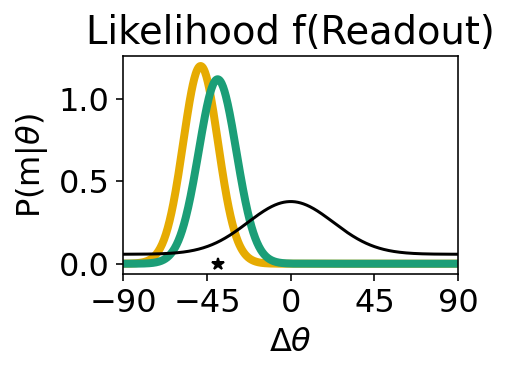

In [19]:
# visualize likelihoods
trial_want =25
# plt.plot(-ori*90/pi,np.exp(LIKs[:,trial_want,:].T))
# plt.show()
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)

these_trials = LIKs[:,trial_want,:].T.copy()
these_trials-=np.max(these_trials,0)
these_trials=np.exp(these_trials)
these_trials/=np.sum(these_trials,0)*stp_size
# plt.prop_cycle(custom_cycler)
plt.plot(-ori*90/pi,these_trials[:,:2],linewidth=4)


current_ori = -theta_deg[trial_want]
# plt.plot([current_ori,current_ori],[0,1],'k')
plt.plot(ori*90/pi,prior,'k')
plt.plot(current_ori,0,'k*')

plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('$\Delta\\theta$')
plt.ylabel('P(m|$\\theta$)')

# these_trials = LIK_Bayes[:,trial_want,:].T.copy(|)
# these_trials-=np.max(these_trials,0)
# these_trials=np.exp(these_trials)
# these_trials/=np.sum(these_trials,0)*stp_size
# plt.plot(-ori*90/pi,these_trials,'--')
# plt.legend(nams+['Prior'])
plt.title('Likelihood f(Readout)')
# sav_fig('Mdl_demo_Likelihood')
plt.show()


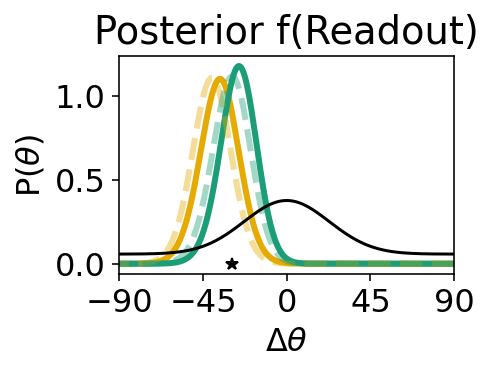

In [20]:
# visualize likelihoods
trial_want = 30
# plt.plot(-ori*90/pi,np.exp(LIKs[:,trial_want,:].T))
# plt.show()
plt.figure(figsize=(3,2))
plt.gca().set_prop_cycle(cyc)

these_trials = LIK_Bayes[:,trial_want,:].T.copy()
these_trials-=np.max(these_trials,0)
these_trials=np.exp(these_trials)
these_trials/=np.sum(these_trials,0)*stp_size
plt.plot(-ori*90/pi,these_trials[:,:2],linewidth=3)

plt.gca().set_prop_cycle(cyc)
these_trials = LIKs[:,trial_want,:].T.copy()
these_trials-=np.max(these_trials,0)
these_trials=np.exp(these_trials)
these_trials/=np.sum(these_trials,0)*stp_size
# plt.prop_cycle(custom_cycler)
plt.plot(-ori*90/pi,these_trials[:,:2],alpha=.4,linewidth=3,linestyle='--')
current_ori = -theta_deg[trial_want]

# plt.plot([current_ori,current_ori],[0,1],'k')
plt.plot(ori*90/pi,prior,'k')
plt.plot(current_ori,0,'k*')

plt.xlim(-90,90)
plt.xticks([-90,-45,0,45,90])
plt.xlabel('$\Delta\\theta$')
plt.ylabel('P($\\theta$)')


# plt.legend(nams)
plt.title('Posterior f(Readout)')
# sav_fig('Mdl_demo_Posterior_Both')
plt.show()
